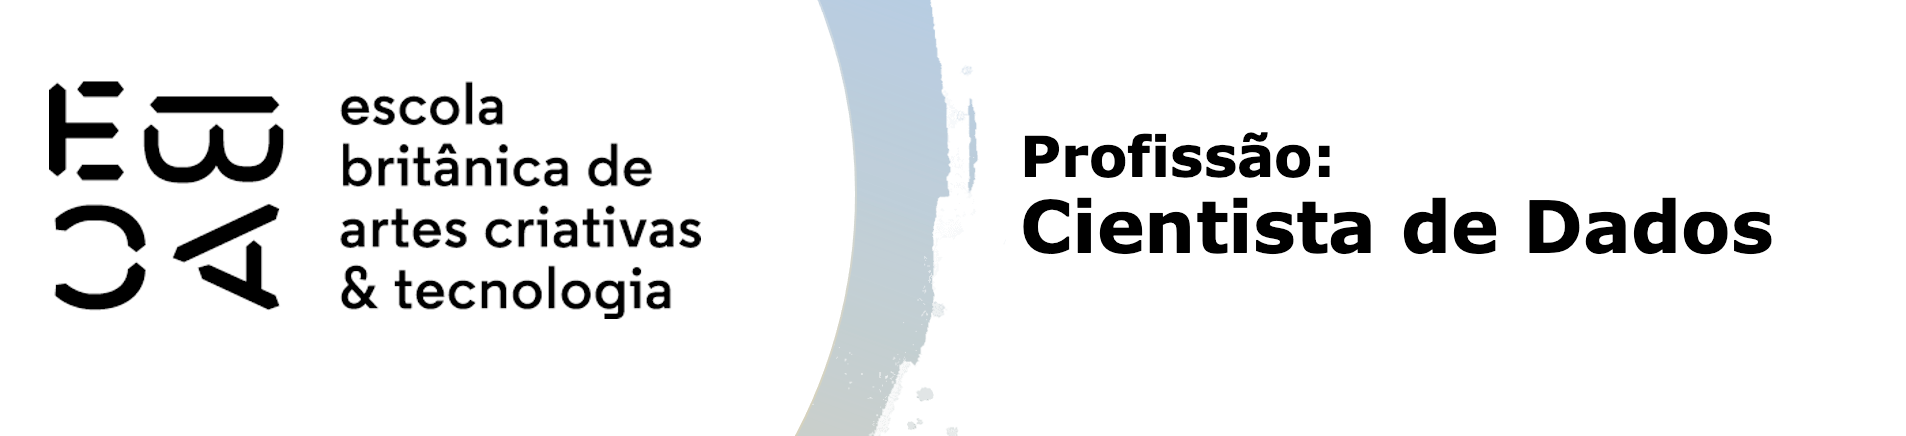

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as shc

In [66]:
df = pd.read_csv('../Mod_27/online_shoppers_intention.csv')
df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [67]:
# Avaliando a porcentagem de clientes que finalizaram a compra
(df.Revenue.value_counts(dropna=True) / df.Revenue.value_counts(dropna=True).sum()) * 100

Revenue
False    84.525547
True     15.474453
Name: count, dtype: float64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

Para a análise da base de dados, selecionamos todas as variáveis execto por aquelas que descrevem o sistema operacional do usuário, navegador, região e tipo de tráfego.

In [68]:
# Selecionando variáveis a trabalhar em X
X = df.loc[:, [col for col in df.columns if col not in ['OperatingSystems', 'Browser', 'Region', 'TrafficType']]]
X.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,Returning_Visitor,True,False


In [69]:
(X['VisitorType'].value_counts() / X['VisitorType'].shape[0]) * 100

VisitorType
Returning_Visitor    85.571776
New_Visitor          13.738848
Other                 0.689376
Name: count, dtype: float64

Como podemos observar acima, da variável **VisitorType** a classe *Other* tem uma proporção muito baixa, portanto iremos eliminar tal classe da base de dados para prosseguirmos.

In [70]:
# Eliminando linhas com classe Other
X = X[X['VisitorType'] != 'Other']
X

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,Returning_Visitor,False,False


Com o intuito de avaliar o agrupamento dos dados pelo algoritmo, vamos criar um agrupamento arbitrário dos clientes, dividindo-os em quatro grupos; clientes recorrentes que finalizaram a compra, clientes recorrentes que não finalizaram a compra, clientes novos que finalizaram a compra e clientes novos que não finalizaram a compra.

In [71]:
# Criando grupo arbitrário para avaliar agrupamento do algoritmo
X['R_groups'] = X[['Revenue', 'VisitorType']].apply(lambda x: ', '.join(x.astype(str)), axis=1)
(X['R_groups'].value_counts() / X['R_groups'].shape[0]) * 100

R_groups
False, Returning_Visitor    74.160882
True, Returning_Visitor     12.004900
False, New_Visitor          10.387913
True, New_Visitor            3.446305
Name: count, dtype: float64

Podemos observar que a base de dados é **desbalanceada** em relação aos clientes recorrentes que não finalizaram a compra. No entanto, como o objetivo é realizar o agrupamento dos dados com base em suas características, essa característica da base não impactará diretamente o desempenho do algoritmo. Ainda assim, pode dificultar a interpretação dos resultados, pois o algoritmo pode formar grupos que refletem a predominância dos dados da classe majoritária, reduzindo a visibilidade de padrões associados à classe minoritária.


Para facilitar as próximas etapas do trabalho, vamos separar uma lista com as variáveis qualitativas do modelo.

In [72]:
# Colhendo nome das colunas de variáveis categóricas
cat_cols = [col for col in X.columns if X[col].dtype not in ['int64', 'float64']]
cat_cols

['Month', 'VisitorType', 'Weekend', 'Revenue', 'R_groups']

In [73]:
# Visualizando distribuição das variáveis contínuas
X.loc[:, X.columns.difference(cat_cols)].describe()

,Administrative,Administrative_Duration,BounceRates,ExitRates,Informational,Informational_Duration,PageValues,ProductRelated,ProductRelated_Duration,SpecialDay
count,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000,12245.000000
mean,2.321029,80.944413,0.022078,0.042932,0.505839,34.630576,5.803858,31.865169,1199.080153,0.061854
std,3.326056,176.579347,0.048201,0.048378,1.272970,141.137281,18.075511,44.548083,1916.732843,0.199540
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,7.000000,186.250000,0.000000
50%,1.000000,8.000000,0.003175,0.025137,0.000000,0.000000,0.000000,18.000000,602.583333,0.000000
75%,4.000000,93.600000,0.016923,0.050000,0.000000,0.000000,0.000000,38.000000,1472.000000,0.000000
max,27.000000,3398.750000,0.200000,0.200000,24.000000,2549.375000,361.763742,705.000000,63973.522230,1.000000


In [74]:
# Visualizando distribuição das variáveis categóricas
for col in cat_cols:
    print((X.loc[:, col].value_counts() / X.shape[0]) * 100)
    print('='*50)

Month
May     27.472438
Nov     24.303797
Mar     15.573704
Dec     13.597387
Oct      4.483463
Sep      3.658636
Aug      3.536137
Jul      3.527971
June     2.343814
Feb      1.502654
Name: count, dtype: float64
VisitorType
Returning_Visitor    86.165782
New_Visitor          13.834218
Name: count, dtype: float64
Weekend
False    76.635361
True     23.364639
Name: count, dtype: float64
Revenue
False    84.548795
True     15.451205
Name: count, dtype: float64
R_groups
False, Returning_Visitor    74.160882
True, Returning_Visitor     12.004900
False, New_Visitor          10.387913
True, New_Visitor            3.446305
Name: count, dtype: float64


Segue abaixo a visualização gráfica do levantamento acima sobre as variáveis categóricas.

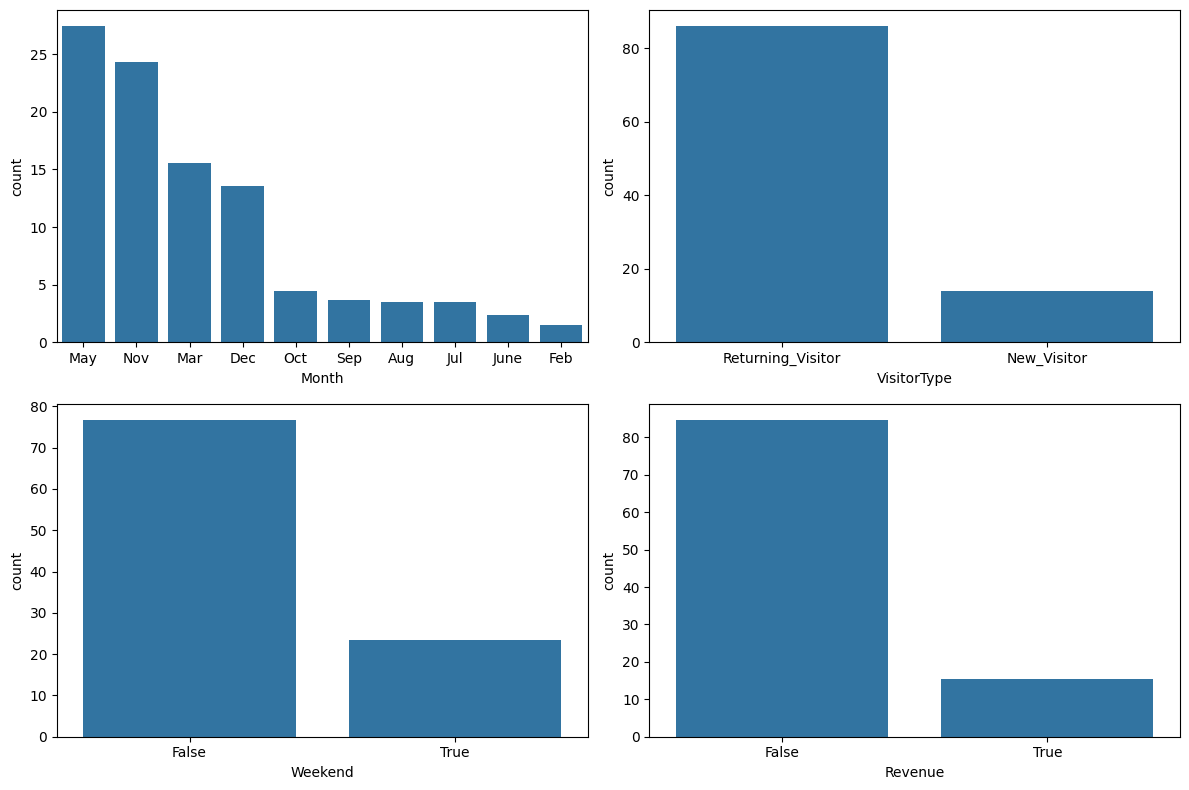

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

sns.barplot(((X.loc[:, cat_cols[0]].value_counts() / X.shape[0]) * 100), ax=axes[0,0])
sns.barplot(((X.loc[:, cat_cols[1]].value_counts() / X.shape[0]) * 100), ax=axes[0,1])
sns.barplot(((X.loc[:, cat_cols[2]].value_counts() / X.shape[0]) * 100), ax=axes[1,0])
sns.barplot(((X.loc[:, cat_cols[3]].value_counts() / X.shape[0]) * 100), ax=axes[1,1])

plt.tight_layout()
plt.show()

Como podemos observar, a maioria dos meses na base de dados são maio, novembro, março e dezembro. Além disso, a maioria dos clientes são clientes recorrentes, a maioria das compras foram realizadas durante a semana e a maioria dos clientes não efetuou uma compra.

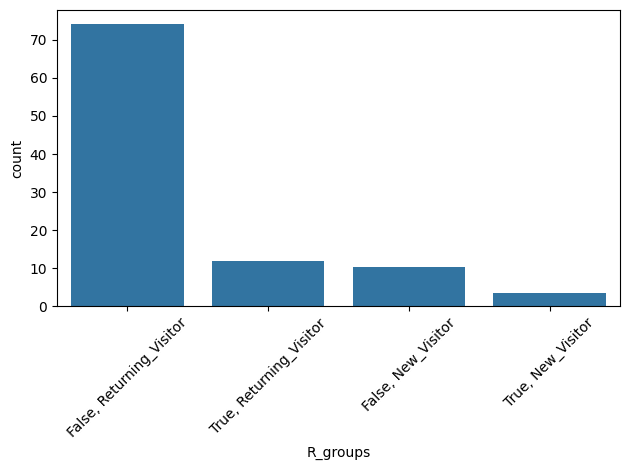

In [76]:
sns.barplot(((X.loc[:, cat_cols[4]].value_counts() / X.shape[0]) * 100))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Acima temos a distribuição da variável categórica que criamos, permitindo uma visualizando quantitativa da mesma.

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

Segue abaixo as variáveis que selecionamos para o treinamento do modelo.

In [77]:
X.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'VisitorType', 'Weekend', 'Revenue', 'R_groups'],
      dtype='object')

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

Para utilizarmos a base, precisamos padronizar as variáveis contínuas e aplicar one-hot encoding nas variáveis categóricas para que o algoritmo possa processa-las.

In [44]:
# Padronizando variáveis contínuas
X_pad = pd.DataFrame(StandardScaler().fit_transform(X.drop(cat_cols, axis=1)),
                    columns=X.drop(cat_cols, axis=1).columns,
                    index=X.index)
X_pad.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,-0.697861,-0.458421,-0.397385,-0.245378,-0.692879,-0.625611,3.691388,3.246799,-0.321103,-0.309994
1,-0.697861,-0.458421,-0.397385,-0.245378,-0.670430,-0.592219,-0.458053,1.179669,-0.321103,-0.309994
2,-0.697861,-0.458421,-0.397385,-0.245378,-0.692879,-0.625611,3.691388,3.246799,-0.321103,-0.309994
3,-0.697861,-0.458421,-0.397385,-0.245378,-0.670430,-0.624220,0.579307,2.006521,-0.321103,-0.309994
4,-0.697861,-0.458421,-0.397385,-0.245378,-0.490842,-0.298218,-0.043109,0.146104,-0.321103,-0.309994


In [78]:
# Unindo base padronizada com variáveis categóricas após aplicar one-hot encoding
X_pad = pd.concat([X_pad, pd.get_dummies(X[cat_cols]).astype('int64')], axis=1)
X_pad.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor,"R_groups_False, New_Visitor","R_groups_False, Returning_Visitor","R_groups_True, New_Visitor","R_groups_True, Returning_Visitor"
0,-0.697861,-0.458421,-0.397385,-0.245378,-0.692879,-0.625611,3.691388,3.246799,-0.321103,-0.309994,...,0,0,0,0,0,1,0,1,0,0
1,-0.697861,-0.458421,-0.397385,-0.245378,-0.670430,-0.592219,-0.458053,1.179669,-0.321103,-0.309994,...,0,0,0,0,0,1,0,1,0,0
2,-0.697861,-0.458421,-0.397385,-0.245378,-0.692879,-0.625611,3.691388,3.246799,-0.321103,-0.309994,...,0,0,0,0,0,1,0,1,0,0
3,-0.697861,-0.458421,-0.397385,-0.245378,-0.670430,-0.624220,0.579307,2.006521,-0.321103,-0.309994,...,0,0,0,0,0,1,0,1,0,0
4,-0.697861,-0.458421,-0.397385,-0.245378,-0.490842,-0.298218,-0.043109,0.146104,-0.321103,-0.309994,...,0,0,0,0,0,1,0,1,0,0


In [79]:
cluster3 = AgglomerativeClustering(n_clusters=3).fit(X_pad)
X['3_grupos'] = cluster3.labels_
X['3_grupos'].value_counts()

3_grupos
0    9120
2    2226
1     899
Name: count, dtype: int64

In [80]:
cluster4 = AgglomerativeClustering(n_clusters=4).fit(X_pad)
X['4_grupos'] = cluster4.labels_
X['4_grupos'].value_counts()

4_grupos
0    6466
1    2654
2    2226
3     899
Name: count, dtype: int64

Vamos visualizar o dendrograma da base.

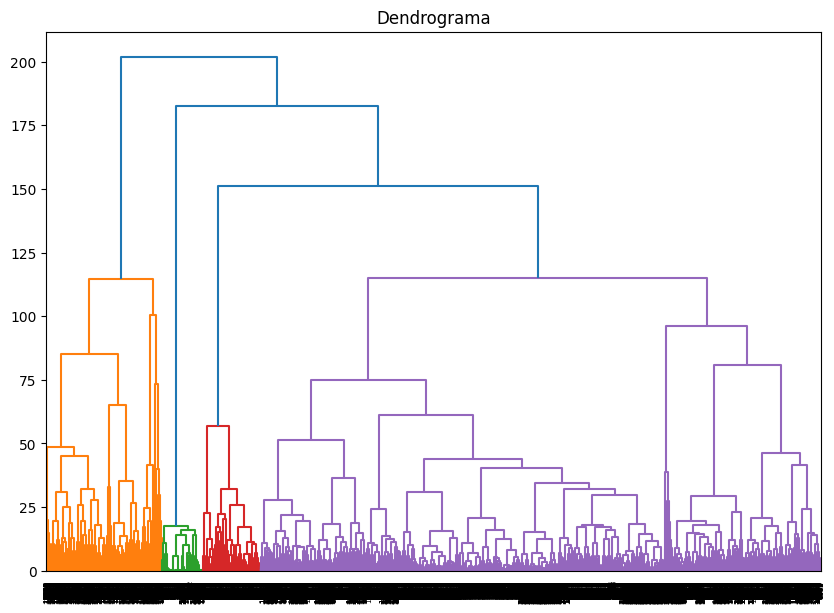

In [47]:
Z = shc.linkage(X_pad.iloc[:, :28], method='ward')

plt.figure(figsize=(10, 7))
plt.title('Dendrograma')
shc.dendrogram(Z)
plt.show()

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [54]:
# Função para visualizar percentagem de cada grupo
def perc(row):
    return (row / X['R_groups'].value_counts().loc[row.name]) * 100

In [55]:
# Avaliando agrupamento com 3 grupos
pd.crosstab(X['R_groups'], X['3_grupos']).apply(perc, axis=1)

3_grupos,0,1,2
R_groups,,,
"False, New_Visitor",94.103774,3.773585,2.122642
"False, Returning_Visitor",78.956062,14.238520,6.805418
"True, New_Visitor",91.943128,8.056872,0.000000
"True, Returning_Visitor",68.435374,31.360544,0.204082


In [59]:
# Avaliando agrupamento com 4 grupos
pd.crosstab(X['R_groups'], X['4_grupos']).apply(perc, axis=1)

4_grupos,0,1,2,3
R_groups,,,,
"False, New_Visitor",91.037736,3.773585,2.122642,3.066038
"False, Returning_Visitor",70.036340,14.238520,6.805418,8.919722
"True, New_Visitor",89.099526,8.056872,0.000000,2.843602
"True, Returning_Visitor",65.102041,31.360544,0.204082,3.333333


Como podemos observar, a maior parte dos dados agrupados pelo algoritmo no grupo 0 também corresponde à maioria dos outros grupos criados de forma arbitrária. Esse padrão pode sugerir que o algoritmo teve dificuldade em formar grupos bem definidos. Entretanto, é fundamental realizar uma análise mais detalhada para confirmar essa hipótese e compreender as possíveis razões por trás desse comportamento.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [60]:
X.groupby(by='3_grupos', observed=True)['BounceRates'].mean()

3_grupos
0    0.013127
1    0.007080
2    0.199397
Name: BounceRates, dtype: float64

In [61]:
pd.crosstab(X['Revenue'], X['3_grupos'])

3_grupos,0,1,2
Revenue,,,
False,8367,1341,645
True,1394,495,3


No agrupamento em 3 grupos, observamos que o grupo 2 apresenta a maior média de **BounceRate**. Ao analisar a distribuição dos grupos pela variável **Revenue**, reforçamos a dificuldade do algoritmo em diferenciar os padrões de compra entre diferentes usuários. Isso fica evidente pelo fato de o grupo 0 concentrar uma quantidade significativa dos dados. É possível que o desbalanceamento de classes esteja influenciando os resultados, já que a maior parte dos grupos identificados corresponde a clientes que não finalizaram a compra, dificultando a captura de padrões mais refinados relacionados aos usuários com comportamento de compra distinto.

In [62]:
X.groupby(by='4_grupos', observed=True)['BounceRates'].mean()

4_grupos
0    0.011013
1    0.007080
2    0.199397
3    0.033691
Name: BounceRates, dtype: float64

In [63]:
pd.crosstab(X['Revenue'], X['4_grupos'])

4_grupos,0,1,2,3
Revenue,,,,
False,7518,1341,645,849
True,1333,495,3,61


Semelhante ao agrupamento anterior, o agrupamento em 4 grupos apresenta o grupo 2 com a maior média de **BounceRate** e uma distribuição dos dados mais concentrada no grupo 0.

### Conclusão

É provável que a abordagem utilizada neste notebook não tenha sido a mais adequada para o agrupamento dos dados. Seria importante aplicar um melhor tratamento aos dados, incluindo estratégias para equilibrar as classes e minimizar o impacto do desbalanceamento. Além disso, é essencial definir claramente quais comportamentos o algoritmo deve identificar, permitindo a criação de uma variável mais representativa e relevante para avaliar o desempenho do modelo. Essas melhorias podem proporcionar resultados mais robustos e interpretações mais significativas.